## Homework 1 | DESIGN 6197/4197 AI & Design: Introduction to Differentiable Inverse Design

Welcome to homework 1! In this assignment, you will build on the Mitsuba tutorials covered in class to develop the design of two lamps.

**First, please make yourself a copy of this notebook before you proceed with any coding.**

So far you have seen how you can use Mitsuba as a general-purpose physically based rendering engine and how to optimize some of the parameters of a scene for a few different scenarios.

In this assignment, you will dig deeper into the structure of a Mitsuba scene and explore how you could use an inverse rendering approach to optimize the light/shadow projections a lighting fixture.

A lamp is a relatively simple object that gives you ample design freedom. You should not aim to reproduce an archetypal desk or floor lamp. You should try and push the definition of a lamp a bit further.

Fundamentally, a lamp is just an object that emits light. Beyond that, there are an infinite number of ways to combine material with this emitter. You can consider a lamp that only emits reflected light or that casts very distinct shadows, you can have multiple emitters or a single one. The emitter(s) can be simple geometric primitives or more complex mesh objects.

See below for additional details on the requirements for each lamp.

>You can use this notebook as a template for HW1. I have left the setup section in place from the in class tutorial walkthrough. The rest of the assignment you will need to complete by adapting the scene files and tutorial code to suit your purpose.
>
>You are not required to do this assignment in google colab. If you prefer, you can download this notebook and set up a local environment. Keep in mind, if you are on a Mac you will not have access to all of the same mitsuba variants. This should not fundamentally be a problem. You should use the llvm_ad_etc... variants for any scene that requires parameter optimization.
>
>I am happy to assist you with local environment setup during office hours.


### Section 0 | Setup

Before we dig into any more details, let's go ahead and get mitsuba installed. Google colab comes with many libraries pre-installed, however, mitsuba is not one of them. To install additional libraries in a colab notebook you can use `!pip` with the normal `install` command. Run the following cell to install mitsuba.

>If you are running this code locally then you should not install mitsuba this way! You will also need to install a few additional libraries (`ipykernel`, `ipywidgets`, and `matplotlib` at a minimum) in order to run all of this code locally.

In [1]:
!pip install mitsuba

After the installation of mitsuba is complete we can go ahead and import `mitsuba`, `drjit`, and `matplotlib.pyplot`.

`mitsuba` is the core library, `drjit` is a custom built just-in-time compiler that handles parallization of operations and supports *automatic differentiation* (AD), `matplotlib` is a common library for plotting and we can use it to view the results of our renders.

In [2]:
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt

#### 2.1 | Optimize your optic

You should revisit the [tutorial on caustic optimization](https://mitsuba.readthedocs.io/en/stable/src/inverse_rendering/caustics_optimization.html) as a starting point for this section. You will need to develop your own target image for this section. You can generate this target image in any image editor of your choosing.



## Create the cylinder lens with meshgrid

In [1]:
import os
from os.path import realpath, join, isfile
import numpy as np
import drjit as dr
import mitsuba as mi

# mi.set_variant('llvm_ad_rgb')
mi.set_variant('cuda_ad_rgb')

SCENE_DIR = realpath('/home/yz864/4197/scenes')

CONFIGS = {
    'example': {
        'emitter': 'bayer',
        'reference': join(SCENE_DIR, 'references/apple.png'),
    },
}

# Pick one of the available configurations.
config_name = 'example'
config = CONFIGS[config_name]
print('[i] Reference image selected:', config['reference'])
mi.Bitmap(config['reference'])

if 'PYTEST_CURRENT_TEST' not in os.environ:
    config.update({
        'render_resolution': (128, 128),
        'heightmap_resolution': (512, 512),
        'n_upsampling_steps': 4,
        'spp': 32,
        'max_iterations': 250,
        'learning_rate': 3e-5,
    })
else:
    config.update({
        'render_resolution': (64, 64),
        'heightmap_resolution': (128, 128),
        'n_upsampling_steps': 0,
        'spp': 8,
        'max_iterations': 25,
        'learning_rate': 3e-5,
    })

output_dir = realpath(join('.', 'outputs', config_name))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

def create_cylindrical_lens_mesh(resolution):
    """
    Create a full cylindrical lens mesh that fits in a 2×2×2 bounding box.

    The UV domain is [0, 1]×[0, 1]. U is mapped to an angle in [-pi, pi] (full wrap)
    and V is mapped linearly to y in [-1, 1]. This produces a standard cylinder of
    radius 1 (x and z vary on the unit circle) and height 2.

    Parameters:
        resolution (tuple[int, int]): (width, height) tessellation resolution of the mesh.

    Returns:
        A Mitsuba Mesh object representing the cylindrical lens.
    """
    # Generate UV coordinates.
    U, V = dr.meshgrid(
        dr.linspace(mi.Float, 0, 1, resolution[0]),
        dr.linspace(mi.Float, 0, 1, resolution[1]),
        indexing='ij'
    )
    texcoords = mi.Vector2f(U, V)

    # Map U in [0,1] to angle in [-pi, pi] so that the entire circumference is covered.
    angle = (U - 0.5) * 2 * np.pi

    # For a full cylinder that fits in a 2×2×2 bounding box:
    #   Set radius = 1  -> x = cos(angle), z = sin(angle)
    #   Set height = 2  -> y = 2*(V - 0.5), so y in [-1, 1].
    x = dr.cos(angle)
    z = dr.sin(angle)
    y = 2.0 * (V - 0.5)
    vertices = mi.Vector3f(x, y, z)

    # Create two triangles per grid cell.
    faces_x, faces_y, faces_z = [], [], []
    for i in range(resolution[0] - 1):
        for j in range(resolution[1] - 1):
            v00 = i * resolution[1] + j
            v01 = v00 + 1
            v10 = (i + 1) * resolution[1] + j
            v11 = v10 + 1
            # First triangle of the cell.
            faces_x.extend([v00, v01])
            faces_y.extend([v10, v10])
            faces_z.extend([v01, v11])
    faces = mi.Vector3u(faces_x, faces_y, faces_z)

    # Instantiate the mesh.
    mesh = mi.Mesh("cylindrical-lens-mesh", resolution[0] * resolution[1], len(faces_x), has_vertex_texcoords=True)

    # Set mesh buffers.
    mesh_params = mi.traverse(mesh)
    mesh_params['vertex_positions'] = dr.ravel(vertices)
    mesh_params['vertex_texcoords'] = dr.ravel(texcoords)
    mesh_params['faces'] = dr.ravel(faces)
    mesh_params.update()

    return mesh

# Use a resolution from the configuration (or default to heightmap_resolution).
lens_res = (config['heightmap_resolution'][0], config['heightmap_resolution'][1] * 10)
lens_fname = join(output_dir, 'lens_{}_{}.ply'.format(*lens_res))

if not isfile(lens_fname):
    m = create_cylindrical_lens_mesh(lens_res)
    m.write_ply(lens_fname)
    print('[+] Wrote cylindrical lens mesh ({}×{} tessellation) file to: {}'.format(*lens_res, lens_fname))


[i] Reference image selected: /home/yz864/4197/scenes/references/apple.png
[i] Results will be saved to: /home/yz864/4197/outputs/example


## [DEBUG]: Assembling the scene

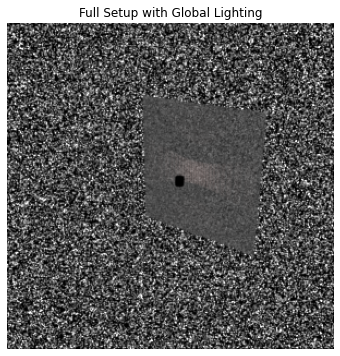

In [2]:
import numpy as np
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt

sensor_to_world = mi.ScalarTransform4f().look_at(
    target=[0, -4, 0],
    origin=[-15, 15, 10], # third coordinate is up
    up=[0, 0, 1]
)

sensor = {
    'type': 'perspective',
    'near_clip': 1,
    'far_clip': 1000,
    'fov': 45,
    'to_world': sensor_to_world,
    'sampler': {
        'type': 'independent',
        'sample_count': 512  # Not really used
    },
    'film': {
        'type': 'hdrfilm',
        'width': 300,    # New resolution width
        'height': 300,   # New resolution height
        'pixel_format': 'rgb',
        'rfilter': {
            'type': 'gaussian'
        }
    },
}

emitter = None
if config['emitter'] == 'gray':
    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'spectrum',
            'value': 0.8
        },
    }
elif config['emitter'] == 'bayer':
    bayer = dr.zeros(mi.TensorXf, (32, 32, 3))
    bayer[ ::2,  ::2, 2] = 2.2
    bayer[ ::2, 1::2, 1] = 2.2
    bayer[1::2, 1::2, 0] = 2.2

    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'bitmap',
            'bitmap': mi.Bitmap(bayer),
            'raw': True,
            'filter_type': 'nearest'
        },
    }

integrator = {
    'type': 'ptracer',
    'samples_per_pass': 256,
    'max_depth': 4,
    'hide_emitters': False,
}

lamp_to_world = (
    mi.ScalarTransform4f()
      .rotate(axis=(1, 0, 0), angle=90)    # make lamp's long axis point along +Z
      .translate([0, 0, 5.0])               # pull it 2 units away from the camera
      .scale([0.3, 0.3, 0.3])
)

scene_dict1 = {
    'type':'scene','sensor':sensor,'integrator':integrator,
    'simple-glass':{
        'type':'dielectric','id':'simple-glass-bsdf',
        'ext_ior':'air','int_ior':1.5,
        'specular_reflectance':{'type':'spectrum','value':0},
    },
    'white-bsdf':{
        'type':'diffuse','id':'white-bsdf',
        'reflectance':{'type':'rgb','value':(1,1,1)},
    },
    'black-bsdf':{
        'type':'diffuse','id':'black-bsdf',
        'reflectance':{'type':'spectrum','value':0},
    },
    'receiving-plane':{
        'type':'obj','id':'receiving-plane',
        'filename':'/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world':mi.ScalarTransform4f().look_at(
            target=[0,1,0],origin=[0,-7,0],up=[0,0,1]
        ).scale((5,5,5)),
        'bsdf':{'type':'ref','id':'white-bsdf'},
    },
    'slab':{
        'type':'obj','id':'slab',
        'filename':'/home/yz864/4197/scenes/meshes/lamp.obj',
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'lens':{
        'type':'ply','id':'lens','filename':lens_fname,
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'point-light':{
        'type':'point',
        'to_world':lamp_to_world,
        'intensity':{'type':'spectrum','value':1},
    },
    'global-light': {
        'type': 'constant',
        'radiance': {
            'type': 'rgb',
            'value': 0.3,
        }
    },
}

# Reload the scene with the updated scene dictionary.
scene = mi.load_dict(scene_dict1)


# Render the updated scene using the configured samples-per-pixel (spp)
rendered_img_setup = mi.render(scene, spp=config['spp'])

# Convert the rendered image to a NumPy array for visualization.
img_np = rendered_img_setup.numpy()
img_np = np.clip(img_np, 0, 1)

# Display the rendered image inline using Matplotlib.
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.title("Full Setup with Global Lighting")
plt.axis('off')
plt.show()


In [1]:
import os
from os.path import realpath, join, isfile
import numpy as np
import drjit as dr
import mitsuba as mi

# mi.set_variant('llvm_ad_rgb')
mi.set_variant('cuda_ad_rgb')

SCENE_DIR = realpath('/home/yz864/4197/scenes')

CONFIGS = {
    'example': {
        'emitter': 'bayer',
        'reference': join(SCENE_DIR, 'references/apple.png'),
        # override default mesh resolution to double vertical sampling
        'lens_res': (1024, 2048),
    },
}

# Pick one of the available configurations.
config_name = 'example'
config = CONFIGS[config_name]
print('[i] Reference image selected:', config['reference'])
mi.Bitmap(config['reference'])

if 'PYTEST_CURRENT_TEST' not in os.environ:
    config.update({
        'render_resolution': (128, 128),
        'heightmap_resolution': (512, 512),
        'n_upsampling_steps': 4,
        'spp': 32,
        'max_iterations': 5000,
        'learning_rate': 3e-5,
    })
else:
    config.update({
        'render_resolution': (64, 64),
        'heightmap_resolution': (128, 128),
        'n_upsampling_steps': 0,
        'spp': 8,
        'max_iterations': 25,
        'learning_rate': 3e-5,
    })

output_dir = realpath(join('.', 'outputs', config_name))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

mi.Thread.thread().file_resolver().append(SCENE_DIR)
def create_cylindrical_lens_mesh(resolution):
    """
    Create a full cylindrical lens mesh in a 2×2×2 box with doubled subdivision:
      - U→angle in [-π,π] around X/Z plane
      - V→height in [-1,1] along Y
    """
    # bump both U and V by a factor of 2
    res_u = resolution[0] * 4
    res_v = resolution[1] * 4

    # Generate UV coordinates at higher resolution
    U, V = dr.meshgrid(
        dr.linspace(mi.Float, 0, 1, res_u),
        dr.linspace(mi.Float, 0, 1, res_v),
        indexing='ij'
    )
    texcoords = mi.Vector2f(U, V)

    # Map U→angle, V→height
    angle = (U - 0.5) * 2 * np.pi
    x = dr.cos(angle)
    z = dr.sin(angle)
    y = 2.0 * (V - 0.5)
    vertices = mi.Vector3f(x, y, z)

    # Re‑build faces at the new resolution
    faces_x, faces_y, faces_z = [], [], []
    for i in range(res_u - 1):
        for j in range(res_v - 1):
            v00 = i * res_v + j
            v01 = v00 + 1
            v10 = (i + 1) * res_v + j
            v11 = v10 + 1
            faces_x.extend([v00, v01])
            faces_y.extend([v10, v10])
            faces_z.extend([v01, v11])

    faces = mi.Vector3u(faces_x, faces_y, faces_z)
    mesh = mi.Mesh("cylindrical-lens-mesh",
                   res_u * res_v,
                   len(faces_x),
                   has_vertex_texcoords=True)

    # Upload the buffers
    mesh_params = mi.traverse(mesh)
    mesh_params['vertex_positions'] = dr.ravel(vertices)
    mesh_params['vertex_texcoords'] = dr.ravel(texcoords)
    mesh_params['faces']            = dr.ravel(faces)
    mesh_params.update()

    return mesh


# Use cylindrical mesh with overridden resolution
lens_res = config.get('lens_res', config['heightmap_resolution'])
lens_fname = join(output_dir, f'lens_{lens_res[0]}_{lens_res[1]}.ply')

if not isfile(lens_fname):
    mesh = create_cylindrical_lens_mesh(lens_res)
    mesh.write_ply(lens_fname)
    print(f'[+] Wrote cylindrical lens mesh {lens_res} to: {lens_fname}')

# --- scene setup remains unchanged below ---

emitter = None
if config['emitter'] == 'gray':
    emitter = {
        'type':'directionalarea',
        'radiance': {'type':'spectrum','value':0.8},
    }
elif config['emitter'] == 'bayer':
    bayer = dr.zeros(mi.TensorXf, (32,32,3))
    bayer[ ::2, ::2, 2] = 2.2
    bayer[ ::2, 1::2,1] = 2.2
    bayer[1::2,1::2,0] = 2.2
    emitter = {
        'type':'directionalarea',
        'radiance':{
            'type':'bitmap','bitmap':mi.Bitmap(bayer),
            'raw':True,'filter_type':'nearest'
        },
    }

integrator = {
    'type':'ptracer','samples_per_pass':256,
    'max_depth':4,'hide_emitters':False,
}

sensor_to_world = mi.ScalarTransform4f().look_at(
    target=[0,-20,0], origin=[0,-5.3,0], up=[0,0,1]
)
resx, resy = config['render_resolution']
sensor = {
    'type':'perspective','near_clip':1,'far_clip':1000,'fov':60,
    'to_world':sensor_to_world,
    'sampler':{'type':'independent','sample_count':512},
    'film':{
        'type':'hdrfilm','width':resx,'height':resy,
        'pixel_format':'rgb','rfilter':{'type':'gaussian'}
    },
}

lamp_to_world = (
    mi.ScalarTransform4f()
      .rotate(axis=(1, 0, 0), angle=90)    # make lamp's long axis point along +Z
      .translate([0, 0, 5])               # pull it 2 units away from the camera
      .scale([0.3, 0.3, 0.3])
)

scene_dict_gray = {
    'type':'scene','sensor':sensor,'integrator':integrator,
    'simple-glass':{
        'type':'dielectric','id':'simple-glass-bsdf',
        'ext_ior':'air','int_ior':1.5,
        'specular_reflectance':{'type':'spectrum','value':0},
    },
    'white-bsdf':{
        'type':'diffuse','id':'white-bsdf',
        'reflectance':{'type':'rgb','value':(1,1,1)},
    },
    'black-bsdf':{
        'type':'diffuse','id':'black-bsdf',
        'reflectance':{'type':'spectrum','value':0},
    },
    'receiving-plane':{
        'type':'obj','id':'receiving-plane',
        'filename':'/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world':mi.ScalarTransform4f().look_at(
            target=[0,1,0],origin=[0,-7,0],up=[0,0,1]
        ).scale((5,5,5)),
        'bsdf':{'type':'ref','id':'white-bsdf'},
    },
    'slab':{
        'type':'obj','id':'slab',
        'filename':'/home/yz864/4197/scenes/meshes/lamp.obj',
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'lens':{
        'type':'ply','id':'lens','filename':lens_fname,
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'point-light':{
        'type':'point',
        'to_world':lamp_to_world,
        'intensity':{'type':'spectrum','value':1},
    },
}

scene_dict_rgb = {
    'type':'scene','sensor':sensor,'integrator':integrator,
    'simple-glass':{
        'type':'dielectric','id':'simple-glass-bsdf',
        'ext_ior':'air','int_ior':1.5,
        'specular_reflectance':{'type':'spectrum','value':0},
    },
    'white-bsdf':{
        'type':'diffuse','id':'white-bsdf',
        'reflectance':{'type':'rgb','value':(1,1,1)},
    },
    'black-bsdf':{
        'type':'diffuse','id':'black-bsdf',
        'reflectance':{'type':'spectrum','value':0},
    },
    'receiving-plane':{
        'type':'obj','id':'receiving-plane',
        'filename':'scenes/meshes/rectangle.obj',
        'to_world':mi.ScalarTransform4f().look_at(
            target=[0,1,0],origin=[0,-7,0],up=[0,0,1]
        ).scale((5,5,5)),
        'bsdf':{'type':'ref','id':'white-bsdf'},
    },
    'slab':{
        'type':'obj','id':'slab',
        'filename':'scenes/meshes/lamp.obj',
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'lens':{
        'type':'ply','id':'lens','filename':lens_fname,
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
}

n_lights = 20

for i in range(n_lights):
    # evenly spaced in model y ∈ [−0.8, +0.8]
    y_i = -0.8 + 1.6 * i / (n_lights - 1)

    # cycle R, G, B
    channel = i % 3
    rgb = [0.0, 0.0, 0.0]
    rgb[channel] = 6.0/10   # per‐channel intensity

    scene_dict_rgb[f'light_{i}'] = {
        'type': 'point',
        'to_world': mi.ScalarTransform4f().translate([0, 0+ y_i, 0.0 ]),
        'intensity': {
            'type': 'rgb',
            'value': tuple(rgb)
        }
    }


scene = mi.load_dict(scene_dict_gray)

def load_ref_image(config, resolution, output_dir):
    b = mi.Bitmap(config['reference'])
    b = b.convert(mi.Bitmap.PixelFormat.RGB, mi.Bitmap.Float32, False)
    if dr.any(b.size() != resolution):
        b = b.resample(resolution)
    mi.util.write_bitmap(join(output_dir,'out_ref.exr'),b)
    print('[i] Loaded reference image from:', config['reference'])
    return mi.TensorXf(b)

sensor = scene.sensors()[0]
crop_size = sensor.film().crop_size()
image_ref   = load_ref_image(config, crop_size, output_dir)

initial_heightmap_resolution = [
    r // (2**config['n_upsampling_steps'])
    for r in config['heightmap_resolution']
]
upsampling_steps = dr.square(
    dr.linspace(mi.Float,0,1,config['n_upsampling_steps']+1,endpoint=False)
    .numpy()[1:]
)
upsampling_steps = (
    config['max_iterations'] * upsampling_steps
).astype(int)
print('Upsample iterations:', upsampling_steps)

heightmap_texture = mi.load_dict({
    'type':'bitmap','id':'heightmap_texture',
    'bitmap':mi.Bitmap(dr.zeros(mi.TensorXf,initial_heightmap_resolution)),
    'raw':True,
})

params       = mi.traverse(heightmap_texture)
params.keep(['data'])
opt          = mi.ad.Adam(lr=config['learning_rate'],params=params)
params_scene = mi.traverse(scene)

positions_initial = dr.unravel(mi.Vector3f,params_scene['lens.vertex_positions'])
normals_initial   = dr.unravel(mi.Vector3f,params_scene['lens.vertex_normals'])
lens_si          = dr.zeros(mi.SurfaceInteraction3f,dr.width(positions_initial))
lens_si.uv       = dr.unravel(type(lens_si.uv),params_scene['lens.vertex_texcoords'])

def apply_displacement(amplitude=1.):
    vmax = 1/100.
    params['data'] = dr.clip(params['data'],-vmax,vmax)
    dr.enable_grad(params['data'])
    height_values    = heightmap_texture.eval_1(lens_si)
    new_positions    = height_values*normals_initial*amplitude + positions_initial
    params_scene['lens.vertex_positions'] = dr.ravel(new_positions)
    params_scene.update()

def scale_independent_loss(image,ref):
    scaled_img = image / dr.mean(dr.detach(image))
    scaled_ref = ref / dr.mean(ref)
    return dr.mean(dr.square(scaled_img - scaled_ref))


[i] Reference image selected: /home/yz864/4197/scenes/references/apple.png
[i] Results will be saved to: /home/yz864/4197/outputs/example
[+] Wrote cylindrical lens mesh (1024, 2048) to: /home/yz864/4197/outputs/example/lens_1024_2048.ply
[i] Loaded reference image from: /home/yz864/4197/scenes/references/apple.png
Upsample iterations: [ 200  800 1800 3200]


Optimising:   0% 0/5000 [00:00<?, ?it/s]

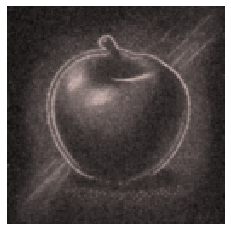

[i] Saved training sequence to /home/yz864/4197/outputs/example/optimisation.gif
387.734059715271  ms per iteration on average


In [2]:
# ======== extra imports & live-preview initialisation (adds visualisation, changes nothing else) ========
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm                      # progress bar that co-exists with display
import imageio                                      ### GIF – fallback to plain imageio

plt.ioff()
_fig, _ax = plt.subplots(figsize=(4, 4))
_img_handle   = None                                # reused AxesImage
_disp_handle  = None                                # reused DisplayHandle
# =======================================================================================================

gif_path   = join(output_dir, 'optimisation.gif')   ### GIF
gif_writer = imageio.get_writer(gif_path, mode='I', fps=10, loop=0)  ### GIF

import time
start_time = time.time()
mi.set_log_level(mi.LogLevel.Warn)
iterations = config['max_iterations']
loss_values = []
spp = config['spp']
mi.set_variant('cuda_ad_rgb')

for it in tqdm(range(iterations), desc='Optimising', ncols=0):
    t0 = time.time()

    # Apply displacement and update the scene BHV accordingly
    apply_displacement()

    # Perform a differentiable rendering of the scene
    image = mi.render(scene, params, seed=it, spp=2 * spp, spp_grad=spp)

    # ---------- GIF frame (every iteration) ----------------------------------
    rgb8 = (np.clip(np.sqrt(image.numpy()), 0.0, 1.0) * 255).astype(np.uint8)
    gif_writer.append_data(rgb8)                          ### GIF
    # -------------------------------------------------------------------------

    # Scale-independent L2 function
    loss = scale_independent_loss(image, image_ref)

    # Back-propagate errors to input parameters and take an optimizer step
    dr.backward(loss)

    # Take a gradient step
    opt.step()

    # Increase resolution of the heightmap
    if it in upsampling_steps:
        opt['data'] = dr.upsample(opt['data'], scale_factor=(2, 2, 1))

    # Carry over the update to our "latent variable" (the heightmap values)
    params.update(opt)

    # Log progress
    elapsed_ms = 1000. * (time.time() - t0)
    current_loss = loss.array[0]
    loss_values.append(current_loss)
    mi.Thread.thread().logger().log_progress(
        it / (iterations-1),
        f'Iteration {it:03d}: loss={current_loss:g} (took {elapsed_ms:.0f}ms)',
        'Caustic Optimization', '')

    # Increase rendering quality toward the end of the optimization
    if it in (int(0.7 * iterations), int(0.9 * iterations)):
        spp *= 2
        opt.set_learning_rate(0.5 * opt.lr['data'])

    # ---------- live preview every 10 iterations -------------------------------------------------------
    if it % 10 == 0:
        _rgb = np.clip(np.sqrt(image.numpy()), 0.0, 1.0)       # quick γ-correction for display
        if _img_handle is None:
            _img_handle = _ax.imshow(_rgb, interpolation='nearest')
            _ax.axis('off')
            _disp_handle = display(_fig, display_id=True)
        else:
            _img_handle.set_data(_rgb)
            _disp_handle.update(_fig)
    # --------------------------------------------------------------------------------------------------

end_time = time.time()
plt.close(_fig)    # clean-up the figure so the notebook shows only the final frame

gif_writer.close()                                      ### GIF
print(f'[i] Saved training sequence to {gif_path}')     ### GIF
print(((end_time - start_time) * 1000) / iterations, ' ms per iteration on average')
mi.set_log_level(mi.LogLevel.Info)


In [3]:
# --- Save final heightmap and displaced mesh ---
mi.set_log_level(mi.LogLevel.Error)

fname = join(output_dir, 'heightmap_final.exr')
mi.util.write_bitmap(fname, params['data'])
print('[+] Saved final heightmap state to:', os.path.basename(fname))

fname = join(output_dir, 'lens_displaced.ply')
apply_displacement()
lens_mesh = [m for m in scene.shapes() if m.id() == 'lens'][0]
lens_mesh.write_ply(fname)
print('[+] Saved displaced lens to:', os.path.basename(fname))

[+] Saved final heightmap state to: heightmap_final.exr
[+] Saved displaced lens to: lens_displaced.ply


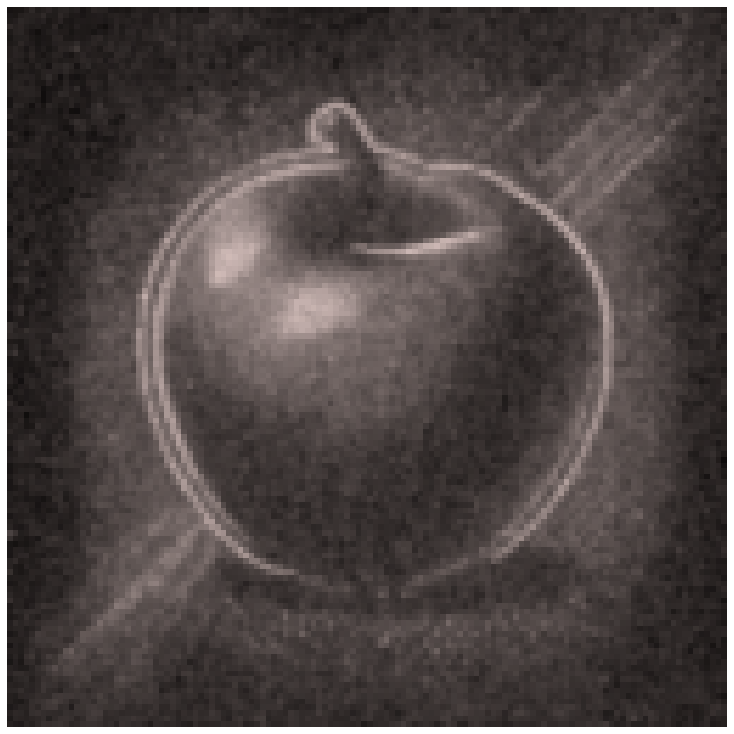

In [4]:
import matplotlib.pyplot as plt

def show_image(ax, img):
    ax.imshow(mi.util.convert_to_bitmap(img))
    ax.axis('off')

fig, ax = plt.subplots(figsize=(11, 10))

show_image(ax, image)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()


Please add a copy of the target image file and the optimized image to the .zip folder requested at the end of the assignment.

#### 2.2 | Render the projection from your optic in a room

Once you have your optimized glass optic you should extract it (along with the emitter and glass 'slab) from your optimized scene and place it into a new room scene similar to the one developed for Lamp 1. Again, you should include the 'mirrorsphere' somewhere in your room.

You can do this by building a new scene and copying over the parameters from your optimized lens or by extracting the relevant elements from the optimization scene and building a new scene around these elements.

You may need to transform the position of the elements from your optimized scene to have them fit in your new 'room' scene. Alternatively, you can build the scene around the existing positon of the optimized elements. Either way, you should set up your new camera in a location where the entire room can be seen.



In [55]:
import os
from os.path import realpath, join

import drjit as dr
import mitsuba as mi

# mi.set_variant('llvm_ad_rgb')
mi.set_variant('cuda_ad_rgb')

SCENE_DIR = realpath('/home/yz864/4197/scenes')

CONFIGS = {
    'example': {
        'emitter': 'bayer',
        'reference': join(SCENE_DIR, 'references/apple.png'),
    },
}


# Pick one of the available configurations.
config_name = 'example'
config = CONFIGS[config_name]

config.update({
    'render_resolution': (128, 128),
    'heightmap_resolution': (512, 512),
    'n_upsampling_steps': 4,
    'spp': 32,
    'max_iterations': 5000,
    'learning_rate': 3e-5,
})

emitter = None
if config['emitter'] == 'gray':
    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'spectrum',
            'value': 0.8
        },
    }
elif config['emitter'] == 'bayer':
    bayer = dr.zeros(mi.TensorXf, (32, 32, 3))
    bayer[ ::2,  ::2, 2] = 2.2
    bayer[ ::2, 1::2, 1] = 2.2
    bayer[1::2, 1::2, 0] = 2.2

    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'bitmap',
            'bitmap': mi.Bitmap(bayer),
            'raw': True,
            'filter_type': 'nearest'
        },
    }

integrator = {
    'type': 'ptracer',
    'max_depth': 16
}

integrator_path = {
    "type": "path",
    "max_depth": 8,
    "hide_emitters": False
}

# Looking at the receiving plane, not looking through the lens
sensor_to_world = mi.ScalarTransform4f().look_at(
    target=[0, -20, 0],
    origin=[0, -4.65, 0],
    up=[0, 0, 1]
)
resx, resy = config['render_resolution']
sensor = {
    'type': 'perspective',
    'near_clip': 1,
    'far_clip': 1000,
    'fov': 45,
    'to_world': sensor_to_world,

    'sampler': {
        'type': 'independent',
        'sample_count': 512  # Not really used
    },
    'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'pixel_format': 'rgb',
        'rfilter': {
            # Important: smooth reconstruction filter with a footprint larger than 1 pixel.
            'type': 'gaussian'
        }
    },
}

move = 5

lamp_to_world = (
    mi.ScalarTransform4f()
      .rotate(axis=(1, 0, 0), angle=90)    # make lamp's long axis point along +Z
      .translate([0, 0, move])               # pull it 2 units away from the camera
      .scale([0.3, 0.3, 0.3])
)

scene = {
    'type': 'scene',
    'sensor': sensor,
    'integrator': integrator,
    # Glass BSDF
    'simple-glass': {
        'type': 'dielectric',
        'id': 'simple-glass-bsdf',
        'ext_ior': 'air',
        'int_ior': 1.5,
        'specular_reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    'white-bsdf': {
        'type': 'diffuse',
        'id': 'white-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 1) },
    },
    'pink-bsdf': {
        'type': 'diffuse',
        'id': 'pink-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 0.2, 1) },
    },
    'yellow-bsdf': {
        'type': 'diffuse',
        'id': 'yellow-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 0) },
    },
    'black-bsdf': {
        'type': 'diffuse',
        'id': 'black-bsdf',
        'reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    # Receiving plane
        'receiving-plane':{
        'type':'obj','id':'receiving-plane',
        'filename':'/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world':mi.ScalarTransform4f().look_at(
            target=[0,1,0],origin=[0,-7,0],up=[0,0,1]
        ).scale((5,5,5)),
        'bsdf':{'type':'ref','id':'white-bsdf'},
    },

    # floor
    'floor': {
        'type': 'obj',
        'id': 'floor',
        'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f().look_at(
                target=[0, -7, 0],
                origin=[0, -7, -1.5],
                up=[0, 1, 0]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },

    # Right wall
    'rightwall': {
        'type': 'obj',
        'id': 'rightwall',
        'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f().look_at(
                target=[0, -7, 0],
                origin=[-1.5, -7, 0],
                up=[0, 0, 1]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'yellow-bsdf'},
    },

    # Left wall
    'leftwall': {
        'type': 'obj',
        'id': 'leftwall',
        'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f().look_at(
                target=[0, -7, 0],
                origin=[1.5, -7, 0],
                up=[0, 0, 1]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'pink-bsdf'},
    },

    # Top light
    # 'toplight': {
    #     'type': 'obj',
    #     'id': 'toplight',
    #     'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
    #     'to_world': \
    #         mi.ScalarTransform4f().look_at(
    #             target=[0, -5, 0],
    #             origin=[0, -5, 1.5],
    #             up=[0, 1, 0]
    #         ).scale((2, 2, 2)),
    #     'bsdf': {'type': 'ref', 'id': 'black-bsdf'},
    #   'emitter': {
    #     'type': 'area',
    #     'radiance': {
    #         'type': 'rgb',
    #         'value': [0.1, 0.1, 0.1]
    #     }
    # }
    # },


    
    # Glass slab, excluding the 'exit' face (added separately below)
    'slab':{
        'type':'obj','id':'slab',
        'filename':'/home/yz864/4197/scenes/meshes/lamp.obj',
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'lens':{
        'type':'ply','id':'lens','filename':"/home/yz864/4197/outputs/example/lens_displaced.ply",
        'to_world':    mi.ScalarTransform4f(),           # pull it 2 units away from the camera,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'point-light':{
        'type':'point',
        'to_world':lamp_to_world,
        'intensity':{'type':'spectrum','value':1},
    },
    'global-light': {
        'type': 'constant',
        'radiance': {
            'type': 'rgb',
            'value': 0.3,
        }
    },

}


scene = mi.load_dict(scene)

Now you need to render this composite scene. You should be able to see the optimized pattern (your target image) projected onto one of the walls of your scene along with the other objects in the room. This render will just be a normal 'forward' render, no further optimization should be required.

You may need to adjust the brightness of your emitter for this step in order to get a legible render.

<ipython-input-56-df3a76ab3406>:45: DeprecationWarning: clamp() is deprecated, please use clip(...)
  side_image = dr.clamp(side_image, 0, 1)


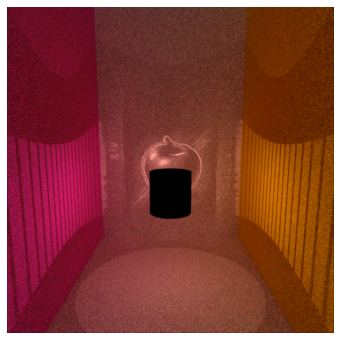

In [56]:
import matplotlib.pyplot as plt
import numpy as np

mi.set_variant('cuda_ad_rgb')

side_sensor_dict = {
    'type': 'perspective',
    'fov': 60,
    # 'to_world': mi.ScalarTransform4f().look_at(
    #     # x increases = left
    #     # x increases = further
    #     origin=[4, 4, 8],  # side + slightly above
    #     target=[0, 0, 0],   # aim at the world origin
    #     up=[0, 0, 1]
    # ),

    'to_world': mi.ScalarTransform4f().look_at(
        # x increases = left
        # y increases = further
        origin=[0, -1, 1],
        target=[0, -7, 0],
        up=[0, 0, 1]
    ),

    'film': {
        'type': 'hdrfilm',
        'width': 512,
        'height': 512,
        'pixel_format': 'rgb',
        'rfilter': {
            'type': 'gaussian'
        }
    },
    'sampler': {
        'type': 'independent',
        'sample_count': 1024
    }

}

side_sensor = mi.load_dict(side_sensor_dict)

side_image = mi.render(scene, sensor=side_sensor, seed=0)

side_image = dr.clamp(side_image, 0, 1)

plt.figure(figsize=(6,6))
plt.imshow(np.array(side_image))
plt.axis('off')
plt.show()


In [54]:
# Keep every 10-th frame from an existing GIF.
# -----------------------------------------------------------------
# Set the paths you want to use **directly as strings**:
src_gif = '/home/yz864/4197/outputs/example/optimisation.gif'      # ← change me
dst_gif = '/home/yz864/4197/outputs/example/optimisation_thinned.gif'       # ← change me
# -----------------------------------------------------------------

import imageio

with imageio.get_reader(src_gif) as reader:
    meta = reader.get_meta_data()                       # carry over FPS/loop
    with imageio.get_writer(dst_gif,
                            mode='I',
                            fps=meta.get('fps', 10),
                            loop=meta.get('loop', 0)) as writer:
        for i, frame in enumerate(reader):
            if i % 50 == 0:                            # keep every 10-th frame
                writer.append_data(frame)

print(f'[i] Saved thinned GIF to {dst_gif}')


[i] Saved thinned GIF to /home/yz864/4197/outputs/example/optimisation_thinned.gif
